In [5]:
# general purpose imports
import os
import sys
import numpy as np
import scipy

# SMRT imports
from smrt import make_snowpack, sensor_list, make_model, sensitivity_study
from smrt.utils import dB

# Graphics import
%matplotlib notebook
import matplotlib.pyplot as plt
import smrt.utils.mpl_plots
color = ['#1f77b4','#ff7f0e','#2ca02c','#d62728']

In [6]:
## prepare inputs: snowpack with two layers

temperature = [265]
thickness = [200]
radius0 = 100

phis = np.arange(1, 4, 0.1)

# create the sensor
radiometer = sensor_list.passive(37e9, 55)

<IPython.core.display.Javascript object>


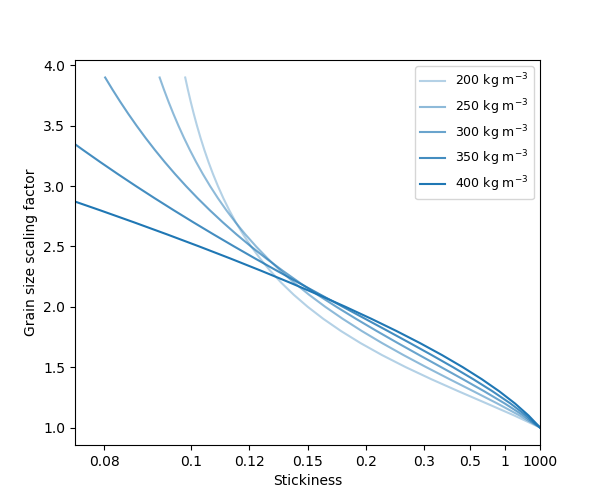

(1000, 0.075)

In [7]:
# create the SMRT Model with emmodel="iba"
m_iba = make_model("iba", "dort")
# run the model


def cost_function(stickiness, TbV_target, density):
    # build a single layer snowpack with stickiness given as input
    try:
        sp = make_snowpack(thickness, "sticky_hard_spheres",
                        density=density, temperature=temperature, radius=[radius0*1e-6], stickiness=stickiness)
        res = m_iba.run(radiometer, sp)
    except smrt.SMRTError:
        return -TbV_target
    return (res.TbV() - TbV_target)  # compute the distance to the target ks

def equivalent_stickiness(density):
    snowpacks = [make_snowpack(thickness, "sticky_hard_spheres",
                            density=[density], temperature=temperature, radius=[phi*radius0*1e-6], stickiness=1000) for phi in phis]

    optimal_stickiness = []
    for i, snowpack in enumerate(snowpacks):
        em = m_iba.run(radiometer, snowpack)
        try:
            optimal_stickiness.append( scipy.optimize.brentq(cost_function, 0.07, 1000, args=(em.TbV(), density)) )
        except ValueError:
            optimal_stickiness.append( np.nan)
    return optimal_stickiness



f, axs =  plt.subplots(1, 1, figsize=(6, 5))
axs = [axs]

for d in [200, 250, 300, 350, 400]:
    axs[0].plot(equivalent_stickiness(d), phis, color=color[0], label='%i kg m$^{-3}$' % d, alpha=(d-100)/300)
    
axs[0].set_ylabel('Grain size scaling factor')
axs[0].set_xlabel ('Stickiness')
axs[0].set_xscale('stickiness_reciprocal')
axs[0].legend(loc='best')
axs[0].set_xlim((1000, 0.075))

In [8]:
for ax in axs: ax.legend(loc='best', prop={'size': 9})
#f.savefig("fig_stickiness_equivalence.pdf")